# Loading the data

In [1]:
# @title Install dependencies

!pip install pandas --quiet
!pip install seaborn --quiet
!pip install  pyarrow # may be needed to read data file

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

## For this example, we have pre-computed event triggered responses and saved them to figshare.
#### To access the full dataset, see `Allen_neuromatch_example_2.ipynb`, or go to the links at the bottom of this notebook
###This cell will download the responses.

In [2]:
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

### Then we open it using the pandas `read_parquet` method


(parquet is just another file format)

In [3]:
filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(filename)

# DATA_ PROCESSING: Start here after loading data

In [4]:
#THIS IS WHERE THE FUN STARTS
# Define a function to map combinations to numbers 1-4
def map_conditions(row):
    if row['exposure_level'] == "familiar" and row['is_change'] == True:
        return 1
    elif row['exposure_level'] == "familiar" and row['is_change'] == False:
        return 2
    elif row['exposure_level'] == "novel" and row['is_change'] == True:
        return 3
    elif row['exposure_level'] == "novel" and row['is_change'] == False:
        return 4


# Apply the function to create the new column
#filtered_df['condition'] = filtered_df.apply(map_conditions, axis=1)

#print(filtered_df.shape)

In [5]:
data['condition'] = data.apply(map_conditions, axis=1)

In [19]:
outliers = []
data_traces = data.trace.values
for i in range(len(data_traces)):
    outliers.append((data_traces[i]<1).all())

data_subset_rmo = data[outliers]

In [20]:
def restrict_neurons_with_all_conditions(df):
    # Group by neuron and find unique conditions for each neuron
    neuron_conditions = df.groupby('cell_specimen_id')['condition'].unique()
    # filtering only neurons that have trials in all 4 conditions
    neurons_with_all_conditions = neuron_conditions[
        neuron_conditions.apply(lambda x: {1, 2, 3, 4}.issubset(x))
    ].index
    # Filter the data for those neurons
    filtered_d = df[df['cell_specimen_id'].isin(neurons_with_all_conditions)]
    return filtered_d
filtered_data = restrict_neurons_with_all_conditions(data_subset_rmo)

In [21]:
def verify_filtered_data(df):
    condition_counts = df.groupby('cell_specimen_id')['condition'].nunique()
    return (condition_counts == 4).all()
print(f"Verification result: {verify_filtered_data(filtered_data)}")

Verification result: True


In [22]:
#how many trials of each type per neuron? -> calculate length of each condition for each neuron - creating the trial counts variable
# Group by cell_id and 'condition', then count the number of occurrences
trial_counts = filtered_data.groupby(['cell_specimen_id', 'condition']).size().reset_index(name='trial_count')

print(trial_counts)


     cell_specimen_id  condition  trial_count
0          1086489847          1          204
1          1086489847          2          190
2          1086489847          3          218
3          1086489847          4          217
4          1086489860          1          203
..                ...        ...          ...
383        1086567017          4          184
384        1086567589          1          493
385        1086567589          2          304
386        1086567589          3          303
387        1086567589          4          152

[388 rows x 3 columns]


In [23]:
# Group by 'condition' and find the minimum 'trial_count' for each condition
min_trial_counts = trial_counts.groupby('condition')['trial_count'].min().reset_index()

# For each condition, find the neuron_id corresponding to the minimum trial_count
#min_trial_neurons = trial_counts.loc[trial_counts.groupby('condition')['trial_count'].idxmin()].reset_index(drop=True)

# Merge the two dataframes to get the condition, trial_count, and neuron_id together
#result = pd.merge(min_trial_counts, min_trial_neurons, on=['condition', 'trial_count'], suffixes=('', '_min'))

# Select only the relevant columns
min_trial_counts = min_trial_counts[['condition', 'trial_count']]

print(min_trial_counts)

   condition  trial_count
0          1          122
1          2          127
2          3           82
3          4          101


In [24]:
#ALTERNATIVE OPTION
# Sort the dataframe by 'condition' and 'trial_count' - in case we did not want the minimum but another benchmark
sorted_trial_counts = trial_counts.sort_values(by=['condition', 'trial_count'])

# Group by 'condition' and take the nth smallest 'trial_count'
second_trial_counts = sorted_trial_counts.groupby('condition').nth(0).reset_index()

print(second_trial_counts)

   condition  cell_specimen_id  trial_count
0          1        1086498976          122
1          2        1086495377          127
2          3        1086490603           82
3          4        1086498820          101


Now we need to get all neurons to have the same number of trials per condition. 

In [25]:
#CALCULATE MIN TRIALS
# Calculate the minimum number of trials for each condition
min_trials_per_condition = trial_counts.groupby('condition')['trial_count'].min()
min_trials_per_condition

condition
1    122
2    127
3     82
4    101
Name: trial_count, dtype: int64

In [26]:
#MIN_TRIALS DICTIONARY
# Convert min_trials_df to a dictionary for quick lookup
min_trials_dict = min_trials_per_condition.to_dict()
print(min_trials_dict)

{1: 122, 2: 127, 3: 82, 4: 101}


In [27]:
# Function to sample trials
def sample_trials(group, min_trials_dict, random_seed=42):
    condition = group['condition'].iloc[0]  # Extract condition from group
    min_trials = min_trials_dict.get(condition, None)  # Get minimum trials for the condition
    if min_trials is not None and len(group) > min_trials:
        return group.sample(min_trials, random_state=random_seed)
    return group


In [28]:
# Group by 'cell_id' and 'condition', then sample trials to match the minimum
balanced_df = (
    filtered_data.groupby(['cell_specimen_id', 'condition'], group_keys=False)
    .apply(lambda x: sample_trials(x, min_trials_dict))
)

#print(balanced_df)

In [29]:
#CHECKS WHETHER THINGS WORKED
#how many trials of each type per neuron? -> calculate length of each condition for each neuron
# Group by cell_id and 'condition', then count the number of occurrences
print(min_trials_dict)
trial_counts2 = balanced_df.groupby(['cell_specimen_id', 'condition']).size().reset_index(name='trial_count')

print(trial_counts2)

{1: 122, 2: 127, 3: 82, 4: 101}
     cell_specimen_id  condition  trial_count
0          1086489847          1          122
1          1086489847          2          127
2          1086489847          3           82
3          1086489847          4          101
4          1086489860          1          122
..                ...        ...          ...
383        1086567017          4          101
384        1086567589          1          122
385        1086567589          2          127
386        1086567589          3           82
387        1086567589          4          101

[388 rows x 3 columns]


array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>]],
      dtype=object)

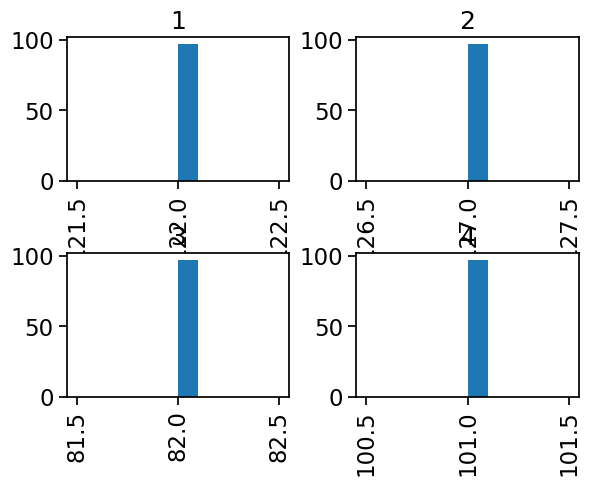

In [30]:
trial_counts2.hist(column='trial_count', by="condition")

In [31]:
# Check if all neurons have the minimum number of trials per condition
correct_counts = trial_counts2.groupby('condition')['trial_count'].nunique() == 1

print("All neurons have the same number of trials per condition:")
print(correct_counts)

All neurons have the same number of trials per condition:
condition
1    True
2    True
3    True
4    True
Name: trial_count, dtype: bool
